In [73]:
import pandas as pd 
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

In [20]:
df = pd.read_csv(data)
column_ = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']
df = df[column_]
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [22]:
#Fill the missing value
df.fillna(0, inplace = True)

In [23]:
df['above_average'] = [1 if price > df['msrp'].mean() else 0 for price in df['msrp']]

In [24]:
# Drop msrp varible
df = df.drop(['msrp'], axis = 1)
df.head()


,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [25]:
#split the dataset
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state= 1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [26]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

In [27]:
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [30]:
numerical_column = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

for c in numerical_column:
    score = roc_auc_score(y_train, df_train[c])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[c])
    print(f'{c:<20} | AUC = {score}')


year                 | AUC = 0.687551492804683
engine_hp            | AUC = 0.9171031265539011
engine_cylinders     | AUC = 0.766116490165669
highway_mpg          | AUC = 0.6330587871772013
city_mpg             | AUC = 0.6734244643245233


so the variable that has the highest AUC is engine_hp

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [31]:
# Drop above_average
df_train = df_train.drop('above_average', axis=1)
df_val = df_val.drop('above_average', axis=1)
df_test = df_test.drop('above_average', axis=1)

In [32]:
# Encoding 
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
X_train

array([[2.700e+01, 6.000e+00, 2.800e+02, ..., 0.000e+00, 0.000e+00,
        2.016e+03],
       [1.800e+01, 6.000e+00, 3.000e+02, ..., 1.000e+00, 0.000e+00,
        2.014e+03],
       [1.900e+01, 4.000e+00, 2.590e+02, ..., 1.000e+00, 0.000e+00,
        2.016e+03],
       ...,
       [3.200e+01, 4.000e+00, 1.300e+02, ..., 0.000e+00, 0.000e+00,
        2.017e+03],
       [1.600e+01, 5.000e+00, 1.620e+02, ..., 1.000e+00, 0.000e+00,
        1.991e+03],
       [1.400e+01, 6.000e+00, 2.400e+02, ..., 0.000e+00, 0.000e+00,
        2.003e+03]])

In [33]:
# Modeling 
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, solver='liblinear')

In [34]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [38]:
y_pred = model.predict_proba(X_val)[:, 1]
round(roc_auc_score(y_val, y_pred), 3)

0.98

the AUC of this model on the validation dataset is 0.979 / 0.98

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88


In [66]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, tn, fp, fn)) 

In [67]:
columns = ['thresholds', 'tp', 'tn', 'fp', 'fn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,thresholds,tp,tn,fp,fn
0,0.00,654,0,1729,0
1,0.01,652,945,784,2
2,0.02,651,1087,642,3
3,0.03,651,1157,572,3
4,0.04,650,1234,495,4


In [68]:
df_scores['precision'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fp'])
df_scores['recall'] = df_scores['tp'] / (df_scores['tp'] + df_scores['fn'])

df_scores.head()

,thresholds,tp,tn,fp,fn,precision,recall
0,0.00,654,0,1729,0,0.274444,1.000000
1,0.01,652,945,784,2,0.454039,0.996942
2,0.02,651,1087,642,3,0.503480,0.995413
3,0.03,651,1157,572,3,0.532298,0.995413
4,0.04,650,1234,495,4,0.567686,0.993884


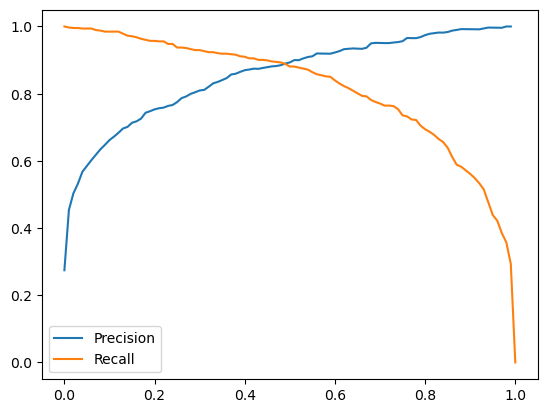

In [69]:
plt.plot(df_scores['thresholds'], df_scores['precision'], label = 'Precision')
plt.plot(df_scores['thresholds'], df_scores['recall'], label = 'Recall')
plt.legend()

so at 0.48 thresholds precision and recall curves intersect

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [71]:
df_scores['f1'] = 2*((df_scores['precision'] * df_scores['recall'])/(df_scores['precision'] + df_scores['recall']))
df_scores[df_scores['f1'] == df_scores['f1'].max()]

,thresholds,tp,tn,fp,fn,precision,recall,f1
51,0.51,576,1665,64,78,0.9,0.880734,0.890263


0.52 is the maximal of threshold

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [75]:
def train(df_train, y_train, solver='liblinear', C=1.0, max_iter=1000, random_state=1):
    dv = DictVectorizer(sparse=False)

    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver=solver, C=C, max_iter=max_iter, random_state=random_state)
    model.fit(X_train, y_train)

    return dv, model


In [76]:
def predict(df, dv, model):
    df_dict = df.to_dict(orient='records')

    X = dv.transform(df_dict)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [77]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['above_average'].values
    y_val = df_val['above_average'].values

    df_train = df_train.drop('above_average', axis=1)
    df_val = df_val.drop('above_average', axis=1)

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

np.array(scores).std().round(3)

0it [00:00, ?it/s]

0.002

standard devidation of the scores across different folds is 0.002

### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [79]:
for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['above_average'].values
        y_val = df_val['above_average'].values

        df_train = df_train.drop('above_average', axis=1)
        df_val = df_val.drop('above_average', axis=1)

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f'C={C} {np.mean(scores):.3f} +- {np.std(scores):.3f}')

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.952 +- 0.002
C=0.1 0.972 +- 0.002
C=0.5 0.978 +- 0.003
C=10 0.984 +- 0.003


C 10